In [1]:
%load_ext autoreload

In [1]:
import numpy as np
import os
import mcubes
import meshcat
import pydrake
from pydrake.geometry import SceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.common import FindResourceOrThrow
from pydrake.multibody.plant import MultibodyPlant, AddMultibodyPlantSceneGraph
from pydrake.multibody.parsing import Parser, LoadModelDirectives, ProcessModelDirectives
from pydrake.multibody.tree import RevoluteJoint
from pydrake.all import ConnectMeshcatVisualizer, InverseKinematics, RigidTransform, RotationMatrix
from pydrake.all import BsplineTrajectoryThroughUnionOfHPolyhedra
import time
from meshcat import Visualizer
from functools import partial

import ipywidgets as widgets
from IPython.display import display

from pydrake.all import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role
import rrt, prm, utils
from sandbox.t_space_utils import (convert_t_to_q, 
                                   convert_q_to_t)

from utils import meshcat_line
from iris_t_space import set_up_iris_t_space

In [2]:
# Setup meshcat
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])
proc2, zmq_url2, web_url2 = start_zmq_server_as_subprocess(server_args=[])

# Build plant and simulation

In [3]:
# Build plant and simulation#settings
q0 = [0.0, 0.0, 0.0]
q_low = [-1.7,-1.7, -2.0]
q_high = [1.7, 1.7, 2.0]
t_low = convert_q_to_t(np.array(q_low).reshape(1,-1)).squeeze()
t_high = convert_q_to_t(np.array(q_high).reshape(1,-1)).squeeze()

#marching cubes
q_low_mc = q_low.copy()
q_high_mc =  q_high.copy()
N = 50

In [4]:
vis = Visualizer(zmq_url=zmq_url)
vis.delete()
vis2 = Visualizer(zmq_url=zmq_url2)
vis2.delete()

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)
tworob_asset = FindResourceOrThrow("drake/sandbox/assets/doublerob.urdf")
#two_dof_asset = FindResourceOrThrow("drake/sandbox/assets/planar2dof.urdf")
box_asset = FindResourceOrThrow("drake/sandbox/assets/box.urdf")

models =[]
models.append(parser.AddModelFromFile(tworob_asset))
#models.append(parser.AddModelFromFile(one_dof_asset))
models.append(parser.AddModelFromFile(box_asset))

idx = 0
for model in models:
    for joint_index in plant.GetJointIndices(model):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, RevoluteJoint):
            joint.set_default_angle(q0[idx])
            idx += 1
            
locs = [[0.,0.,0.],[0.,0.,0.]]
idx = 0
for model in models:
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base", model), RigidTransform(locs[idx]))
    idx+=1

plant.Finalize()

visualizer = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False, )

diagram = builder.Build()
visualizer.load()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
diagram.Publish(context)

joints = []
idx = 0
for model in models:
    jointindx = plant.GetJointIndices(model)
    for j in jointindx:
        joint = plant.get_mutable_joint(j)
        if isinstance(joint, RevoluteJoint):
            joints.append(joint)
            joints[-1].set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([np.array([q_high[idx]])]))
            idx +=1
        
    
def set_joint_ang(val, idx):
    joints[idx].set_angle(plant_context, val)
    
def set_joint_angles(vals):
    joints[0].set_angle(plant_context, vals[0])
    joints[1].set_angle(plant_context, vals[1])
    joints[2].set_angle(plant_context, vals[2])
    
ik = InverseKinematics(plant, plant_context)
collision_constraint = ik.AddMinimumDistanceConstraint(0.001, 0.01)

def eval_cons(q0, q1, q2, c, tol):
        return 1-1*float(c.evaluator().CheckSatisfied([q0, q1, q2], tol))

col_func_handle = partial(eval_cons, c=collision_constraint, tol=0.01)

def eval_cons_rational(t0, t1, t2, c, tol):
    q = convert_t_to_q(np.array([t0, t1, t2]).reshape(1,-1)).squeeze() 
    return col_func_handle(*q)
   
col_func_handle_rational = partial(eval_cons_rational, c=collision_constraint, tol=0.01)

def showres(q):
    set_joint_ang(q[0],0)
    set_joint_ang(q[1],1)
    set_joint_ang(q[2],2)
    col = col_func_handle(*q)
    t = convert_q_to_t(np.array(q).reshape(1,-1)).squeeze()
    if col:
        vis2["q"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0xFFB900))
        vis2["q"].set_transform(
                meshcat.transformations.translation_matrix(t))
    else:
        vis2["q"].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0x3EFF00))
        vis2["q"].set_transform(
                meshcat.transformations.translation_matrix(t))
    diagram.Publish(context)
    print("              ", end = "\r")
    print(col , end = "\r")

sliders = []
sliders.append(widgets.FloatSlider(min=q_low[0], max=q_high[0], value=0, description='q0'))
sliders.append(widgets.FloatSlider(min=q_low[1], max=q_high[1], value=0, description='q1'))
sliders.append(widgets.FloatSlider(min=q_low[2], max=q_high[2], value=0, description='q2'))

q = q0.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    #print(q, end="\r")
    showres(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6006...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
Connected to meshcat-server.


In [5]:
#marching cubes
N = 50
vertices, triangles = mcubes.marching_cubes_func(tuple(t_low), tuple(t_high), N, N, N, col_func_handle_rational, 0.5)
vis2["collision_constraint"].set_object(
            meshcat.geometry.TriangularMeshGeometry(vertices, triangles),
            meshcat.geometry.MeshLambertMaterial(color=0xff0000, wireframe=True))
q = q0.copy()
showres(q)

In [6]:
for slider in sliders:
    display(slider)

display(vis.jupyter_cell())
display(vis2.jupyter_cell())

FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q1', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q2', max=2.0, min=-2.0)

In [7]:
#SPP + IRIS / RRT / PRM  CONFIG + viz
start_q = np.array([0.2, -1.6, 1.5])
target_q = np.array([0.8,-0.9,1.5])
start = convert_q_to_t(start_q.reshape(1,-1))
target = convert_q_to_t(target_q.reshape(1,-1))

#
#plot start and target
mat = meshcat.geometry.MeshLambertMaterial(color=0xFFDD36)
mat.reflectivity = 1.0
vis2['start'].set_object(
                meshcat.geometry.Sphere(0.03), mat)
vis2['start'].set_transform(
                meshcat.transformations.translation_matrix(start.reshape(-1,)))

mat = meshcat.geometry.MeshLambertMaterial(color=0x06D300)
mat.reflectivity = 1.0
vis2['target'].set_object(
                meshcat.geometry.Sphere(0.03), mat)
vis2['target'].set_transform(
                meshcat.transformations.translation_matrix(target.reshape(-1,)))

def draw_traj_tspace(traj, maxit, name):
    #evals end twice fix later
    for it in range(maxit):
        pt = traj.value(it*traj.end_time()/maxit)
        pt_nxt = traj.value((it+1)*traj.end_time()/maxit)
        
        pt_q = convert_t_to_q(pt.reshape(1,-1)).squeeze()

        mat = meshcat.geometry.MeshLambertMaterial(color=0xFFF812)
        mat.reflectivity = 1.0
        vis2[name]['traj']['points' + str(it)].set_object( meshcat_line(pt.squeeze(), pt_nxt.squeeze(),width = 0.03), mat)
        
        set_joint_angles(pt_q.reshape(-1,))
        tf_l2 = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(3)))
        R_l2 = tf_l2.rotation()
        tl_l2 = R_l2@np.array([0,0,0.9]) + tf_l2.translation()

        tf_la = plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(4)))
        R_la = tf_la.rotation()
        tl_la = R_la@np.array([0,0,1.2]) + tf_la.translation()


        mat = meshcat.geometry.MeshLambertMaterial(color=0x0029F1)
        mat.reflectivity = 1.0
        vis[name]['traj']['link2']['points' + str(it)].set_object(
                    meshcat.geometry.Sphere(0.02), mat)
        vis[name]['traj']['link2']['points' + str(it)].set_transform(
                    meshcat.transformations.translation_matrix(tl_l2))
        mat = meshcat.geometry.MeshLambertMaterial(color=0x07F100)
        mat.reflectivity = 1.0
        vis[name]['traj']['linka']['points' + str(it)].set_object(
                    meshcat.geometry.Sphere(0.02), mat)
        vis[name]['traj']['linka']['points' + str(it)].set_transform(
                    meshcat.transformations.translation_matrix(tl_la))

## CONSTRUCT T SPACE IRIS ##


In [8]:
iris_rational_space, query, forward_kin = set_up_iris_t_space(plant, scene_graph, context, settings = None)

In [9]:
seed_points_q = np.array([[0.0, 0, 0], # startpoint
                        [0.8, -0.8, 1.3],  # blue low green up
                        [0.1, -1.2, 0.9],     # green low other up
                        [0.2, -0.6, 1.6],
                        [-0.5, -1.0, 1.9]])[::-1, :]    # passing

seed_points = convert_q_to_t(seed_points_q)


regions = []
ellipses = []
for i in range(seed_points.shape[0]):
    
    start_time = time.time()
    hpoly = iris_rational_space(query, seed_points[i,:], require_containment_points=[seed_points[i,:]], iteration_limit=100)
#     hpoly = iris_cspace(query, seed_points[i,:], require_containment_points=[seed_points[i,:]], iteration_limit=100)
    ellipse = hpoly.MaximumVolumeInscribedEllipsoid()
    print("Time: %6.2f \tVolume: %6.2f \tCenter:" % (time.time() - start_time, ellipse.Volume()),
          ellipse.center(), flush=True)
    regions.append(hpoly)
    ellipses.append(ellipse)
print("SUCCESS")

for i in range(seed_points.shape[0]):
    vis2['iris']['seedpoints']["seedpoint"+str(i)].set_object(
                meshcat.geometry.Sphere(0.1), meshcat.geometry.MeshLambertMaterial(color=0xFFB900))
    vis2['iris']['seedpoints']["seedpoint"+str(i)].set_transform(
                meshcat.transformations.translation_matrix(seed_points[i,:]))

geomA=planar2dof_robot::link2_Collision@0000000004057bf8, geomB=box_scene::box3_Collision@0000000004051bb8
geomA=planar2dof_robot::link1_Collision@0000000004057568, geomB=box_scene::box2_Collision@0000000004051708
snopt_example=[-0.30976193  1.39838259 -0.54630249], growth = 2961.5372005300596
snopt_example=[-0.30976193  1.39838259 -0.54630249], growth = 2961.5371896461584
snopt_example=[-0.30976193  1.39838259 -0.54630249], growth = 2961.5371787617914
snopt_example=[-0.30976193  1.39838259 -0.54630249], growth = 2961.537167878356
snopt_example=[-0.30976193  1.39838259 -0.54630249], growth = 2961.537156993989
geomA=planar2dof_robot::linka_Collision@0000000004050f88, geomB=box_scene::box1_Collision@0000000004051258
geomA=planar2dof_robot::linka_Collision@0000000004050f88, geomB=box_scene::box4_Collision@0000000004057388
snopt_example=[-0.25534192  1.39838259  0.04181233], growth = 345879.04195942846
geomA=planar2dof_robot::link2_Collision@0000000004057bf8, geomB=box_scene::box2_Collisio

geomA=planar2dof_robot::link2_Collision@0000000004057bf8, geomB=box_scene::box3_Collision@0000000004051bb8
geomA=planar2dof_robot::link1_Collision@0000000004057568, geomB=box_scene::box2_Collision@0000000004051708
snopt_example=[-0.30976193  0.48305507 -0.68413681], growth = 129458.65716340987
snopt_example=[-0.30976193  0.48305507 -0.68413681], growth = 129458.65709144936
snopt_example=[-0.30976193  0.48305507 -0.68413681], growth = 129458.65709144925
snopt_example=[-0.30976193  0.48305507 -0.68413681], growth = 129458.65709144925
snopt_example=[-0.30976193  0.48305507 -0.68413681], growth = 129458.65709144925
geomA=planar2dof_robot::linka_Collision@0000000004050f88, geomB=box_scene::box1_Collision@0000000004051258
geomA=planar2dof_robot::linka_Collision@0000000004050f88, geomB=box_scene::box4_Collision@0000000004057388
snopt_example=[0.05004171 0.48305507 0.04181236], growth = 527002.1893411321
geomA=planar2dof_robot::link2_Collision@0000000004057bf8, geomB=box_scene::box2_Collision@

geomA=planar2dof_robot::link2_Collision@0000000004057bf8, geomB=box_scene::box3_Collision@0000000004051bb8
geomA=planar2dof_robot::link1_Collision@0000000004057568, geomB=box_scene::box2_Collision@0000000004051708
snopt_example=[-0.30976193  0.          0.        ], growth = 95952.45239518493
snopt_example=[-0.30976193  0.          0.        ], growth = 95952.452395185
snopt_example=[-0.30976193  0.          0.        ], growth = 95952.452395185
snopt_example=[-0.30976193  0.          0.        ], growth = 95952.452395185
snopt_example=[-0.30976193  0.          0.        ], growth = 95952.452395185
geomA=planar2dof_robot::linka_Collision@0000000004050f88, geomB=box_scene::box1_Collision@0000000004051258
geomA=planar2dof_robot::linka_Collision@0000000004050f88, geomB=box_scene::box4_Collision@0000000004057388
snopt_example=[0.         0.         0.04181236], growth = 1748.273122088455
geomA=planar2dof_robot::link2_Collision@0000000004057bf8, geomB=box_scene::box2_Collision@0000000004051

In [10]:
def inpolycheck(t0,t1,t2, A, b):
    t = np.array([t0, t1, t2])
    res = np.min(1.0*(A@t-b<=0))
    #print(res)
    return res

meshes = []
col1 = 0x002BFF
col2 = 0x3EFF00 
idx = 0
step = 1/(1.0*len(regions))

for region in regions:
    A = region.A()#[:, (0,2,1)]
    b = region.b()
    col_hand = partial(inpolycheck, A=A, b=b)
    vertices, triangles = mcubes.marching_cubes_func(tuple(t_low), tuple(t_high), 50, 50, 50, col_hand, 0.5)
    regstr = "regions" +str(idx)
    ellstr = "ellipse" +str(idx)
    mat = meshcat.geometry.MeshLambertMaterial(color= int((1-idx*step)*col1 + idx*step*col2), wireframe=True)
    mat.opacity = 0.3
    vis2['iris']['regions'][regstr].set_object(
            meshcat.geometry.TriangularMeshGeometry(vertices, triangles),
            mat)
    
    C = ellipses[idx].A()#[:, (0,2,1)]
    d = ellipses[idx].center()#[[0,2,1]]
    radii, R = np.linalg.eig(C.T@C)
    R[:,0] = R[:,0]*np.linalg.det(R)
    Rot = RotationMatrix(R)
 
    transf = RigidTransform(Rot, d)
    mat = meshcat.geometry.MeshLambertMaterial(color= int((1-idx*step)*col1 + idx*step*col2), wireframe=True)
    mat.opacity = 0.15
    vis2['iris']['ellipses'][ellstr].set_object(
            meshcat.geometry.Ellipsoid(np.divide(1,np.sqrt(radii))),
            meshcat.geometry.MeshLambertMaterial(color= int((1-idx*step)*col1 + idx*step*col2), wireframe=True))

    vis2['iris']['ellipses'][ellstr].set_transform(transf.GetAsMatrix4())
    
    idx+=1

In [11]:
# Solve path planning
start_time = time.time()
spp = BsplineTrajectoryThroughUnionOfHPolyhedra(start.squeeze(), target.squeeze(), regions)
spp.set_max_velocity([.3, .3, .3])
spp.set_extra_control_points_per_region(3)

# print(spp.num_regions())
traj_iris = spp.SolveVerbose()
print(time.time() - start_time)
print(traj_iris.start_time())
print(traj_iris.end_time())
draw_traj_tspace(traj_iris, 100, 'iris')

0.6835169792175293
0.0
11.30834580665258


In [12]:
#rrt cfg
limits = [np.array(t_low), np.array(t_high)]
mat = meshcat.geometry.MeshLambertMaterial(color= 0x000000 , wireframe=True)

def plotting_fn(parent, child, pos_samp, idx, mat, width):
    vis2['rrt']['tree']['line' + str(idx)].set_object( meshcat_line(parent.pos, child.pos, width), mat)
    
plotting_fn_handle = partial(plotting_fn, mat = mat, width = 0.01)

def collision(pos, col_func_handle):
    return col_func_handle(pos[0], pos[1], pos[2])
    
rrt_col_fn_handle = partial(collision, col_func_handle = col_func_handle_rational)
    
RRT = rrt.RRT(start = start.squeeze(),
              goal = target.squeeze(),
              limits = limits,
              col_func_handle=rrt_col_fn_handle,
              max_extend_length=0.1,
              extend_steps=0.002,
              init_goal_sample_rate=0.1,
              goal_sample_rate_scaler=0.9,
              verbose = True, 
              plotcallback = plotting_fn_handle,
              sample_collision_free= False)

success, path = RRT.run(8000)
if success:
    mat = meshcat.geometry.MeshLambertMaterial(color= 0xFFF812 , wireframe=True)
    mat.wireframeLinewidth = 2.0
    num_waypoints = len(path)
    #for idx in range(num_waypoints-1):
    #    vis2['rrt']['path']['path' + str(idx)].set_object( meshcat_line(path[idx], path[idx+1],width = 0.01), mat)
    traj_rrt= utils.PWLinTraj(path, 5.0)
    draw_traj_tspace(traj_rrt, 60, 'rrt')

0
it: 0 distance to target:  0.577 goalsample prob:  0.281
it: 2 distance to target:  0.479 goalsample prob:  0.369
it: 4 distance to target:  0.391 goalsample prob:  0.448
it: 8 distance to target:  0.343 goalsample prob:  0.492
it: 10 distance to target:  0.319 goalsample prob:  0.513
it: 12 distance to target:  0.317 goalsample prob:  0.515
it: 433 distance to target:  0.316 goalsample prob:  0.516
it: 638 distance to target:  0.313 goalsample prob:  0.518
1000
it: 1635 distance to target:  0.306 goalsample prob:  0.525
it: 1636 distance to target:  0.208 goalsample prob:  0.613
it: 1638 distance to target:  0.110 goalsample prob:  0.701
it: 1639 distance to target:  0.012 goalsample prob:  0.789
it: 1641 distance to target:  0.002 goalsample prob:  0.798
[RRT] Collision free path found in  1641  steps


In [13]:
#prm cfg
limits = [np.array(t_low), np.array(t_high)]
mat = meshcat.geometry.MeshLambertMaterial(color= 0x000000 , wireframe=True)

def plotting_fn(nodes, adjacency_list, mat, width):
    plt_idx = 0
    for node_idx in range(nodes.shape[0]):
        pos1 = nodes[node_idx, :]
        for edge_idx in range(len(adjacency_list[node_idx])): 
            pos2 = nodes[adjacency_list[node_idx][edge_idx], :]
            vis2['prm']['roadmap']['line' + str(plt_idx)].set_object( meshcat_line(pos1, pos2, width), mat)
            plt_idx +=1
            
plotting_fn_handle = partial(plotting_fn, mat = mat, width = 0.01)

def collision(pos, col_func_handle):
    return col_func_handle(pos[0], pos[1], pos[2])

prm_col_fn_handle = partial(collision, col_func_handle = col_func_handle_rational)

PRM = prm.PRM( 
            limits,
            num_points = 400,
            col_func_handle = prm_col_fn_handle,
            num_neighbours = 5, 
            dist_thresh = .5,
            num_col_checks = 10,
            verbose = True,
            plotcallback = plotting_fn_handle
            )

PRM.add_start_end(start.squeeze(), target.squeeze())
PRM.plot()
path, sp_length = PRM.find_shortest_path()

mat = meshcat.geometry.MeshLambertMaterial(color= 0xFFF812 , wireframe=True)
mat.wireframeLinewidth = 2.0
num_waypoints = len(path)
#for idx in range(num_waypoints-1):
#    vis2['prm']['path']['path' + str(idx)].set_object( meshcat_line(path[idx], path[idx+1],width = 0.01), mat)
traj_prm = utils.PWLinTraj(path, 5.0)
draw_traj_tspace(traj_prm, 60, 'prm')

[PRM] Samples 0
[PRM] Samples 30
[PRM] Samples 60
[PRM] Samples 90
[PRM] Samples 120
[PRM] Samples 150
[PRM] Samples 180
[PRM] Samples 210
[PRM] Samples 240
[PRM] Samples 270
[PRM] Samples 300
[PRM] Samples 330
[PRM] Samples 360
[PRM] Samples 390
[PRM] Nodes connected: 0
[PRM] Nodes connected: 20
[PRM] Nodes connected: 40
[PRM] Nodes connected: 60
[PRM] Nodes connected: 80
[PRM] Nodes connected: 100
[PRM] Nodes connected: 120
[PRM] Nodes connected: 140
[PRM] Nodes connected: 160
[PRM] Nodes connected: 180
[PRM] Nodes connected: 200
[PRM] Nodes connected: 220
[PRM] Nodes connected: 240
[PRM] Nodes connected: 260
[PRM] Nodes connected: 280
[PRM] Nodes connected: 300
[PRM] Nodes connected: 320
[PRM] Nodes connected: 340
[PRM] Nodes connected: 360
[PRM] Nodes connected: 380
76 disconnected nodes [[  3]
 [  6]
 [ 12]
 [ 19]
 [ 26]
 [ 28]
 [ 42]
 [ 48]
 [ 51]
 [ 57]
 [ 58]
 [ 63]
 [ 76]
 [ 79]
 [ 82]
 [ 85]
 [ 91]
 [ 94]
 [ 95]
 [ 97]
 [101]
 [103]
 [106]
 [115]
 [118]
 [128]
 [131]
 [135]
 

In [16]:
#animate Iris + spp sol
substeps = 1000
its = 5
utils.animate_t(traj_iris, showres, substeps, convert_t_to_q, its*substeps)
            

In [17]:
#animate RRT sol
substeps = 1000
its = 5
utils.animate_t(traj_rrt, showres, substeps, convert_t_to_q, its*substeps)
            

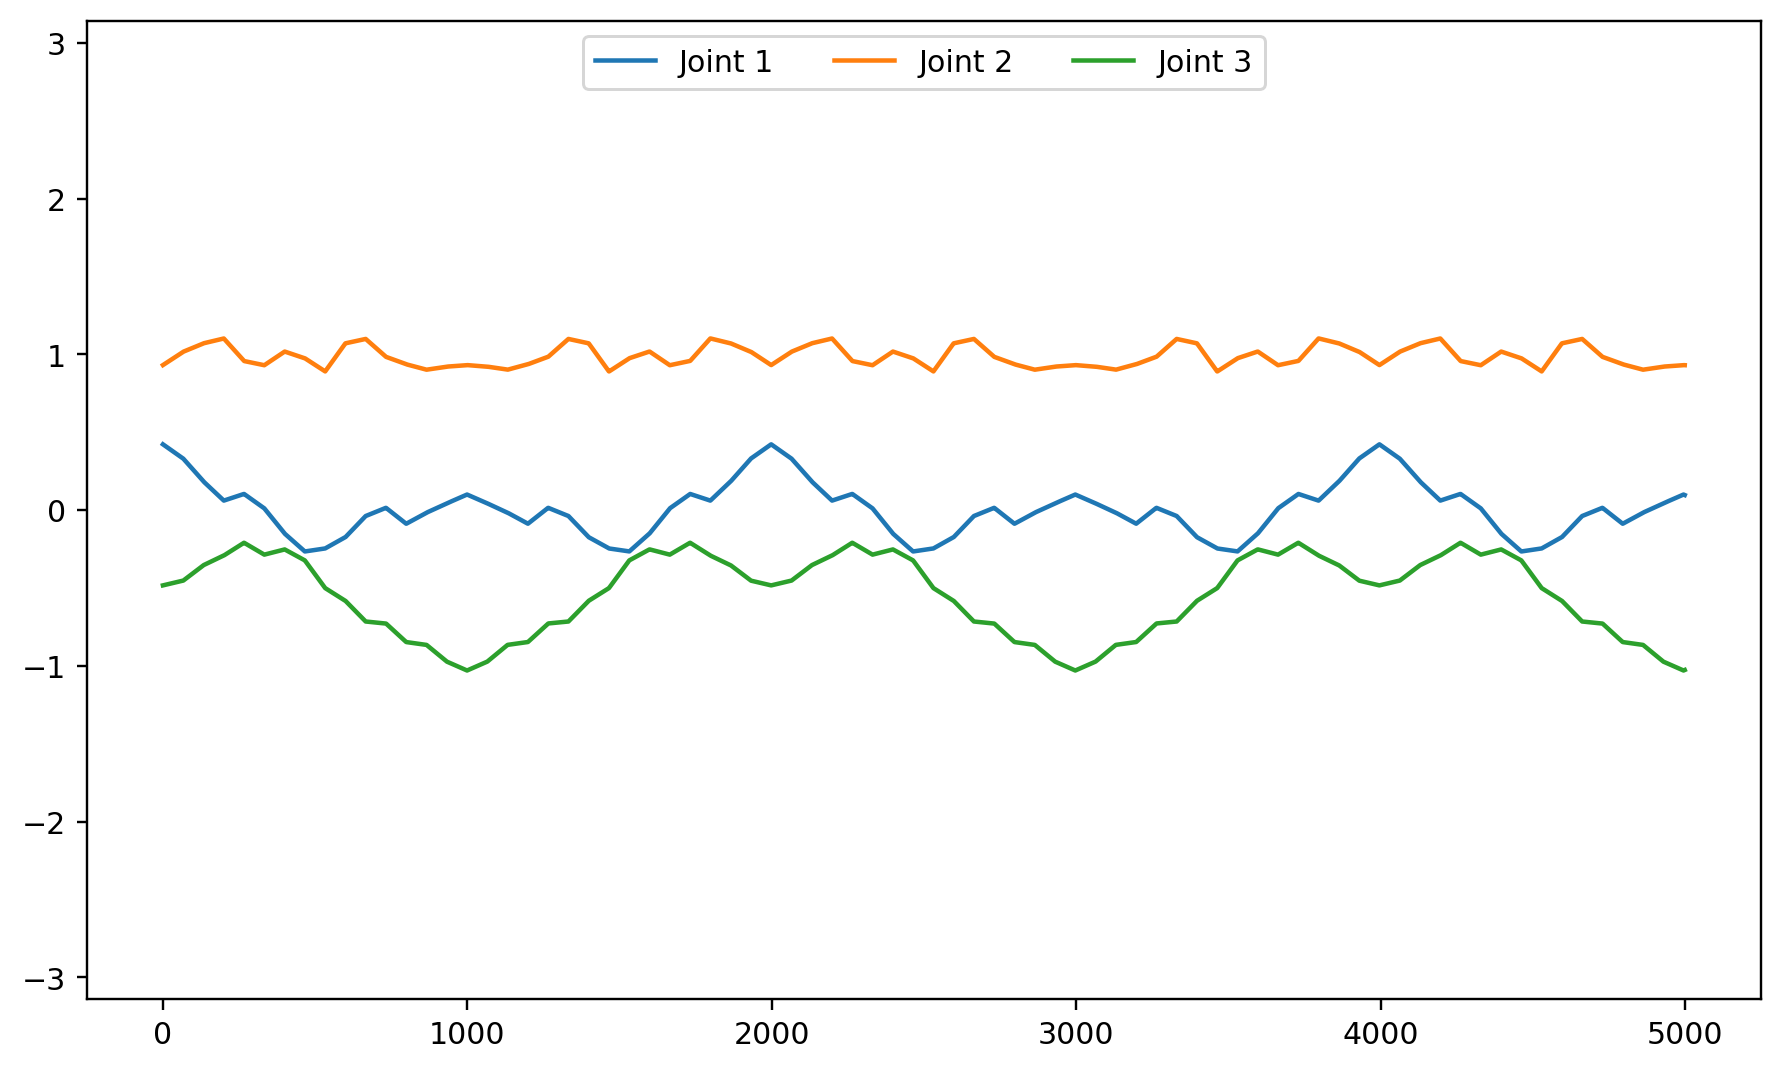

In [20]:
#animate PRM
substeps = 1000
its = 5
#utils.plot(traj_prm, substeps, its*substeps)
utils.animate_t(traj_prm, showres, substeps, convert_t_to_q, its*substeps)
            


In [ ]:
def do_iris(q_seed, iris_options):
    start_time = time.time()
    hpoly = IrisInConfigurationSpace(plant, plant_context, q_seed, iris_options)
    ellipse = hpoly.MaximumVolumeInscribedEllipsoid()
    print("Time: %6.2f \tVolume: %6.2f \tCenter:" % (time.time() - start_time, ellipse.Volume()),
          ellipse.center(), flush=True)
    return ellipse, hpoly

q_low_np = np.array(q_low)
q_high_np = np.array(q_high)

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 50
iris_options.enable_ibex = False

regions = []
ellipses = []
its = 6
seed_points = [start, target]

for point in seed_points:
    ell, reg = do_iris(point, iris_options)
    regions.append(reg)
    ellipses.append(ell)
    
for _ in range(its):
    #rejection sampling to get initial feasible point 
    found = False
    while not found:
        t = np.random.rand(3)
        q_samp = (1-t)*q_low_np + t*q_high_np
        found = (col_func_handle(*q_samp)==0.0)
    print("point found: ", q_samp)
    ell, reg = do_iris(q_samp, iris_options)
    if ell.Volume() < 10.0:
        regions.append(reg)
        ellipses.append(ell)
    